In [1]:
# %reload_ext signature
# %matplotlib notebook

import pandas as pd
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

import cv2
import random
from tqdm.notebook import tqdm

import _pickle as pickle
import random
def save(file,name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'wb')
    else:
        outfile = open(name+'.pickle', 'wb')
    pickle.dump(file, outfile)
    outfile.close
    
def load(name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'rb')
    else:
        outfile = open(name+'.pickle', 'rb')
    file = pickle.load(outfile)
    outfile.close
    return file

In [2]:
def find_bound(im, tres, axis):
    inf = 0
    sup = im.shape[axis]
    cond = True
    tres = tres
    temp = 0
    for i,elt in enumerate(im.sum(axis = axis)):
        if abs(elt) <=tres and cond == True:
            temp = i
        if abs(elt) >=tres:
            cond = False
            inf = temp
            

        if abs(elt)  <= tres and cond == False:
            sup = i
            cond = True
    return inf, sup

def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    a = []
    for i, im in enumerate(scans):
        im = im.pixel_array
#         print(im.shape)
        if i == 0:
            tres = 10
            inf_x, sup_x = find_bound(im, tres, 1)
            inf_y, sup_y = find_bound(im,tres,0)
        im = im[inf_x:sup_x,inf_y: sup_y]
        a.append(im)
#         print(im.shape)
    
#     image = np.stack([s.pixel_array for s in scans])
    image = np.stack(a)
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
#     mean = np.mean(img)
#     std = np.std(img)
#     img = img-mean
#     img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/8 and B[2]<col_size/8*7:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img


def make_3d_vid(X):
    %matplotlib notebook
    fig1 = plt.figure(num='Lung', figsize = (5,5))

    ax1 = fig1.add_subplot(111)
    ax1.set_xlabel('x label')

    end = X.shape[0]
    for i in range(end):
        ax1.cla()  # Clear only 2nd figure's axes, figure 1 is ADDITIVE
        ax1.set_title('Axes title')  # Reset as removed by cla()

        ax1.imshow(X[i,:,:], cmap = 'gray')
    #     ax2.plot(range(i,end), range(i,end), 'rx')
        fig1.canvas.draw()
    #     plt.pause(0.001)

    %matplotlib notebook
    fig1 = plt.figure(num='Lung', figsize = (5,5))

    ax1 = fig1.add_subplot(111)
    ax1.set_xlabel('x label')

    end = X.shape[1]
    for i in range(end):
        ax1.cla()  # Clear only 2nd figure's axes, figure 1 is ADDITIVE
        ax1.set_title('Axes title')  # Reset as removed by cla()

        ax1.imshow(X[:,i,:], cmap = 'gray')
    #     ax2.plot(range(i,end), range(i,end), 'rx')
        fig1.canvas.draw()
    #     plt.pause(0.001)

    %matplotlib notebook
    fig1 = plt.figure(num='Lung', figsize = (5,5))

    ax1 = fig1.add_subplot(111)
    ax1.set_xlabel('x label')

    end = X.shape[2]
    for i in range(end):
        ax1.cla()  # Clear only 2nd figure's axes, figure 1 is ADDITIVE
        ax1.set_title('Axes title')  # Reset as removed by cla()

        ax1.imshow(X[:,:,i], cmap = 'gray')
    #     ax2.plot(range(i,end), range(i,end), 'rx')
        fig1.canvas.draw()
    #     plt.pause(0.001)

## Test des fonctions

In [ ]:
# data_path = "./train/ID00010637202177584971671"
# data_path = './train/ID00007637202177411956430'
data_path = './train/ID00014637202177757139317'
# data_path = './train/' + os.listdir('./train')[0]
output_path = working_path = "./output"
g = glob(data_path + '/*.dcm')

# Print out the first 5 file names to verify we're in the right folder.
print("Total of %d DICOM images.\nFirst 5 filenames:" % len(g))
print('\n'.join(g[:5]))

In [ ]:
id=0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

plt.imshow(imgs[1])

In [ ]:
#make_3d_vid(imgs)

In [ ]:
np.save(output_path + "fullimages_%d.npy" % (id), imgs)
file_used=output_path+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
print("Slice Thickness: %f" % patient[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

In [ ]:
print("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [patient[0].SliceThickness,1,1])
print("Shape after resampling\t", imgs_after_resamp.shape)

In [ ]:
make_3d_vid(imgs_after_resamp)

In [ ]:
imgs_after_resamp = (imgs_after_resamp - imgs_after_resamp.mean())/imgs_after_resamp.std()

In [ ]:
img = imgs_after_resamp[15]
img_tr = make_lungmask(img, display=True)

In [ ]:
imgs_after_resamp.max()

In [ ]:
img_after_filter = np.array([make_lungmask(img, display=False) for img in tqdm(imgs_after_resamp)])

In [ ]:
make_3d_vid(img_after_filter)

## Batch processing

In [ ]:
def process_3d(ids):
    data_path = './train/' + ids
    output_path = working_path = "./output"
    g = glob(data_path + '/*.dcm')
    
    patient = load_scan(data_path)
    imgs = get_pixels_hu(patient)
    id = 0
    np.save(output_path + "fullimages_%d.npy" % (id), imgs)
    file_used=output_path+"fullimages_%d.npy" % id
    imgs_to_process = np.load(file_used).astype(np.float64) 
    
#     imgs_to_process = imgs
    imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
    
    save(imgs_after_resamp, ids, 'raw_3d')
    
    imgs_after_resamp = (imgs_after_resamp - imgs_after_resamp.mean())/imgs_after_resamp.std()
    img_after_filter = np.array([make_lungmask(img, display=False) for img in tqdm(imgs_after_resamp)])
    
    save(img_after_filter, ids, 'filtered_3d')

In [ ]:
def process_2d(ids):
    data_path = './train/' + ids
    output_path = working_path = "./output"
    g = glob(data_path + '/*.dcm')
    
    patient = load_scan(data_path)
    imgs = get_pixels_hu(patient)
    id = 0
    np.save(output_path + "fullimages_%d.npy" % (id), imgs)
    file_used=output_path+"fullimages_%d.npy" % id
    imgs_to_process = np.load(file_used).astype(np.float64) 
    
#     imgs_to_process = imgs
    imgs_after_resamp, spacing = resample(imgs_to_process, patient, [patient[0].SliceThickness,1,1])
    
    save(imgs_after_resamp, ids, 'raw_2d')
    
    imgs_after_resamp = (imgs_after_resamp - imgs_after_resamp.mean())/imgs_after_resamp.std()
    img_after_filter = np.array([make_lungmask(img, display=False) for img in tqdm(imgs_after_resamp)])
    
    
    for i, elt in enumerate(img_after_filter):  
        save(elt, ids + '_' + str(i), 'filtered_2d')

In [ ]:

ids = 'ID00014637202177757139317'
process_2d(ids)

In [ ]:
missing = 0
for ids in tqdm(os.listdir('./train')):
    
    print(ids)
    
    if not(ids + '_0.pickle') in os.listdir('./filtered_2d'):
        print('process')
        try:
            process_2d(ids)
        except:
            print('miss')
            missing += 1

In [ ]:
for elt in tqdm(os.listdir('D:/pulmon')):
    
    if not(elt in os.listdir('./filtered_3d')):
        try:
            print(elt)
            elt = elt.split('.')[0]
            imgs_after_resamp = load('D:/pulmon/' + str(elt))

            imgs_after_resamp = (imgs_after_resamp - imgs_after_resamp.mean())/imgs_after_resamp.std()
            img_after_filter = np.array([make_lungmask(img, display=False) for img in tqdm(imgs_after_resamp)])

            save(img_after_filter, elt, 'filtered_3d')
        except:
            1
    

## Linking with data

In [ ]:
import pandas as pd
import random

In [ ]:
df1 = pd.read_csv('train.csv')

In [ ]:
df1.head()

In [ ]:
elt = os.listdir('./filtered_3d')[0]
elt = elt.split('.')[0]
X = load(elt, 'filtered_3d')


In [ ]:
((X != 0)*1).sum()/1e3

In [ ]:
df = []

train = 0
test = 0

for elt in tqdm(os.listdir('./filtered_3d')):
    elt = elt.split('.')[0]
    df2 = df1[df1['Patient'] == elt]
    
    a = random.uniform(0,1)
    if a >= 0.9:
        df2['Train'] = 0
        test+=1
    else:
        df2['Train'] = 1
        train+=1
    
    X = load(elt, 'filtered_3d')
    vol = ((X != 0)*1).sum()/1e6
    
    df2['Volume (dm3)'] = vol
    
    df.append(df2)
df = pd.concat(df)

In [ ]:
df = pd.read_csv('train_split.csv')

In [ ]:
df1 = []
for ids in df['Patient'].unique():
    df2 = df[df['Patient'] == ids]
    
    df2 = df2.sort_values(by = ['Weeks'])
    
    df2['initial_FVC'] = df2.iloc[0]['FVC']
    df2['initial_percent'] = df2.iloc[0]['Percent']
    df2['initial_Age'] = df2.iloc[0]['Age']
    df2['male'] = 1 if df2.iloc[0]['Sex'] == 'Male' else 0
    df2['female'] = 1 if df2.iloc[0]['Sex'] == 'Female' else 0
    
    df2['exsmoker'] = 1 if df2.iloc[0]['SmokingStatus'] == 'Ex-smoker' else 0
    df2['smoker'] = 1 if df2.iloc[0]['SmokingStatus'] == 'Currently smokes' else 0
    df2['nonsmoker'] = 1 if df2.iloc[0]['SmokingStatus'] == 'Never smoked' else 0
    
    df2['relative_week'] = df2['Weeks'] - df2.iloc[0]['Weeks']
    
    df1.append(df2)
    
df1 = pd.concat(df1)
    

In [ ]:
df1.head()

In [ ]:
df1.to_csv('train_features.csv')

In [ ]:
df1.head()

## Making prediction

In [ ]:
df = pd.read_csv('train_features.csv')

In [ ]:
df = df.sample(n = df.shape[0])

In [ ]:
df.columns

In [ ]:
features = [
#             'Sex',
#             'SmokingStatus',
    
            
            'Weeks', 
            'Age',
            'Volume (dm3)', 
            'initial_FVC',
            'initial_percent', 
            'initial_Age', 
            'male', 
            'female', 
            'exsmoker',
            'smoker', 
            'nonsmoker',
            'relative_week'
           ]

target = 'FVC'

In [ ]:
X_train = df[df['Train'] == 1][features].values
X_test = df[df['Train'] == 0][features].values

cat_features = [0,1]

y_train = df[df['Train'] == 1][target].values.astype('float')
y_test = df[df['Train'] == 0][target].values.astype('float')

X_val = pd.concat([df[df['Patient'] == elt].sort_values(by = ['Weeks']).iloc[-3:] for elt in df[df['Train'] == 0]['Patient'].unique()])[features].values
y_val = pd.concat([df[df['Patient'] == elt].sort_values(by = ['Weeks']).iloc[-3:] for elt in df[df['Train'] == 0]['Patient'].unique()])[target].values.astype('float')

In [ ]:
X_val.shape

In [ ]:
def metric(true, pred):
    return np.mean(abs(true-pred))

def comp_metric(true, pred, conf):
    conf1 = np.maximum(conf, np.zeros(len(conf))+70)
    
    ab = np.minimum(abs(true-pred), np.zeros(len(conf))+1000)
    
    first_term = -np.sqrt(2)*ab/conf1
    second_term = -np.log(np.sqrt(2)*conf1)
    return np.mean(first_term + second_term)

In [ ]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()

# from sklearn.svm import SVR
# clf = SVR(kernel = 'linear')

# import lightgbm
# clf = lightgbm.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.1, 
#                        n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, 
#                        min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, 
#                        subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, 
#                        reg_lambda=0.0, random_state=None, n_jobs=- 1, silent=True, 
#                        importance_type='split')

# from sklearn.ensemble import RandomForestRegressor
# clf = RandomForestRegressor(n_estimators=10, criterion='mse', max_depth=5, min_samples_split=2, 
#                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
#                             max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
#                             bootstrap=True, oob_score=False, n_jobs=8)

# from catboost import CatBoostRegressor
# clf = CatBoostRegressor(iterations=150,
#                           learning_rate=1,
#                           task_type="GPU",
#                           depth=5,
#                        custom_metric=['MAE'])


# clf.fit(X_train, y_train, cat_features, eval_set=(X_test, y_test), verbose = 1)
clf.fit(X_train, y_train)

In [ ]:
for i,elt in enumerate(features):
    print(elt + '         : '+ str(clf.coef_[i]))
#     print(elt + '         : '+ str(clf.feature_importances_[i]))

In [ ]:
true = y_train
pred = clf.predict(X_train)

print(metric(true, pred))

x = []
y = []

for i in range(80,500):
    x.append(comp_metric(true, pred, np.zeros(len(true))+i))
    y.append(i)
print(max(x))
# %matplotlib notebook
# plt.figure(0)
# plt.plot(true, pred)
# plt.figure(1)
# # %matplotlib notebook
# plt.plot(y, x)


In [ ]:
true = y_test
pred = clf.predict(X_test)

print(metric(true, pred))

x = []
y = []

for i in range(80,500):
    x.append(comp_metric(true, pred, np.zeros(len(true))+i))
    y.append(i)
print(max(x))
# %matplotlib notebook
# plt.figure(0)
# plt.plot(true, pred)
# plt.figure(1)
# # %matplotlib notebook
# plt.plot(y, x)


In [ ]:
true = y_val
pred = clf.predict(X_val)

print(metric(true, pred))

x = []
y = []

for i in range(80,500):
    x.append(comp_metric(true, pred, np.zeros(len(true))+i))
    y.append(i)
    
print(max(x))
# %matplotlib notebook
# plt.figure(0)
# plt.plot(true, pred)
# plt.figure(1)
# # %matplotlib notebook
# plt.plot(y, x)


In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

In [ ]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

#=============================#
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

#=================
def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    #x = L.Dense(100, activation="relu", name="d3")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    model.compile(loss=mloss(0.2), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

In [ ]:
net = make_model(X_train.shape[1])

In [ ]:
net.summary()

In [ ]:
cnt = 0
EPOCHS = 800


stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=20, verbose=1, mode='auto',
    baseline=None, restore_best_weights=True
)
reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, 
                                                     mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.00001)



net.fit(X_train, y_train,  batch_size=15, epochs=EPOCHS, 
            validation_data=(X_test, y_test), verbose=1, callbacks = [stop, reduce])

In [ ]:
pred = net.predict(X_val)
true = y_val
sigma = (pred[:,2]-pred[:,1])
pred = pred[:,1] 
print(metric(true, pred))

comp_metric(true, pred, sigma)

In [ ]:
x = []
y = []

mult = np.arange(0.3,5,0.01)

for i in mult:
    x.append(comp_metric(true, pred, sigma*i))
    y.append(i)

plt.plot(y,x)

In [ ]:
pred = net.predict(X_val)
true = y_val
sigma = (pred[:,2]-pred[:,1])*1.8
pred = pred[:,1] 
print(metric(true, pred))

comp_metric(true, pred, sigma)

## Contrastive Learning

In [3]:
os.listdir('./filtered_2d')

['ID00007637202177411956430_0.pickle',
 'ID00007637202177411956430_1.pickle',
 'ID00007637202177411956430_10.pickle',
 'ID00007637202177411956430_11.pickle',
 'ID00007637202177411956430_12.pickle',
 'ID00007637202177411956430_13.pickle',
 'ID00007637202177411956430_14.pickle',
 'ID00007637202177411956430_15.pickle',
 'ID00007637202177411956430_16.pickle',
 'ID00007637202177411956430_17.pickle',
 'ID00007637202177411956430_18.pickle',
 'ID00007637202177411956430_19.pickle',
 'ID00007637202177411956430_2.pickle',
 'ID00007637202177411956430_20.pickle',
 'ID00007637202177411956430_21.pickle',
 'ID00007637202177411956430_22.pickle',
 'ID00007637202177411956430_23.pickle',
 'ID00007637202177411956430_24.pickle',
 'ID00007637202177411956430_25.pickle',
 'ID00007637202177411956430_26.pickle',
 'ID00007637202177411956430_27.pickle',
 'ID00007637202177411956430_28.pickle',
 'ID00007637202177411956430_29.pickle',
 'ID00007637202177411956430_3.pickle',
 'ID00007637202177411956430_4.pickle',
 'ID0

In [4]:
ids = 'ID00009637202177434476278_2'
img = load(ids, 'filtered_2d')

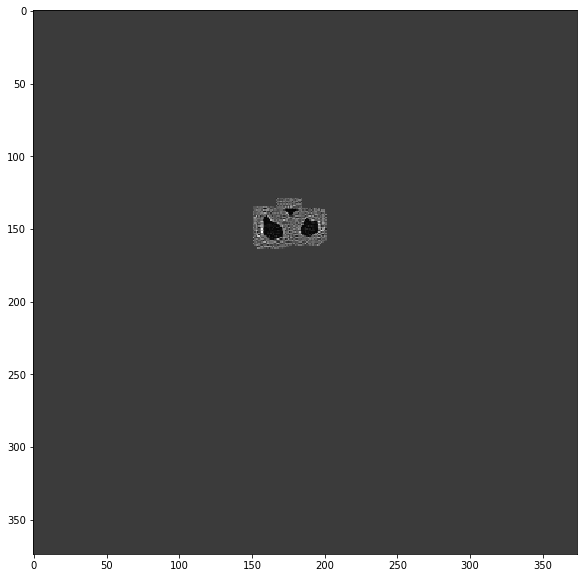

In [5]:
# %matplotlib notebook
plt.figure(figsize = (10,10))
plt.imshow(img, cmap = 'gray')

In [6]:
img1 = trim_resize(img, 256)

plt.figure(figsize = (10,10))
plt.imshow(img1, cmap = 'gray')

print(img1.shape)

NameError: name 'trim_resize' is not defined

In [7]:
np.zeros((300,300))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
def trim_resize(img, size):
    img1 = img[~np.all(img == 0, axis=1)]
    img1 = img1[:,~np.all(img1 == 0, axis=0)]
    
    # add blank areas
    imsize = img1.shape[0]
    
    ht, wd= img1.shape
    
    ww = max(ht,wd)
    hh = max(ht,wd)
    
    if ww > size:
        result = np.zeros((hh,ww))
        # compute center offset
        xx = (ww - wd) // 2
        yy = (hh - ht) // 2
        # copy img image into center of result image
        result[yy:yy+ht, xx:xx+wd] = img1
        result = cv2.resize(result, (size, size))
    else:
        hh = size
        ww = size
        result = np.zeros((hh,ww))
        # compute center offset
        xx = (ww - wd) // 2
        yy = (hh - ht) // 2
        # copy img image into center of result image
        result[yy:yy+ht, xx:xx+wd] = img1
    
    return result

In [9]:
def image_generator(path, batch_size = 64, img_size = 128, latent_dim = 1024):
    
    while True:
          # Select files (paths/indices) for the batch
            
        files = os.listdir(path)
#         batch_paths  = np.random.choice(a = files, 
#                                           size = int(batch_size/2))
        batch_in1  = list(np.zeros(int(batch_size/2)))
        batch_in2  = list(np.zeros(int(batch_size/2)))
        batch_output = np.zeros((batch_size, latent_dim))
          
          # Read in each input, perform preprocessing and get labels
        for i in range(len(batch_in1)):
            cond = True
            while cond:
                try:
                    input_path = random.choice(files)
#                     print(input_path)
                    img = load(path+'/'+input_path.split('.')[0])
                    batch_in1[i], batch_in2[i] = build_sub_img(img, img_size)
                    cond = False
                except:
                    cond = True
            
            
            
        batch_input = batch_in1 + batch_in2
            
          # Return a tuple of (input, output) to feed the network
        batch_x = np.array( batch_input )
        
        batch_x = batch_x.reshape(batch_size, batch_x.shape[1], batch_x.shape[1], 1)
        
        batch_y = np.array( batch_output )
        
        yield( batch_x, batch_y )
        
def image_generator2(path, batch_size = 64, img_size = 128, latent_dim = 1024):
    
    while True:
          # Select files (paths/indices) for the batch
            
        files = os.listdir(path)
#         batch_paths  = np.random.choice(a = files, 
#                                           size = int(batch_size/2))
        batch_in1  = list(np.zeros(int(batch_size)))
        batch_output = np.zeros((batch_size, latent_dim))
          
          # Read in each input, perform preprocessing and get labels
        for i in range(len(batch_in1)):
            cond = True
            while cond:
                try:
                    input_path = random.choice(files)
#                     print(input_path)
                    img = load(path+'/'+input_path.split('.')[0])
                    batch_in1[i] = trim_resize(img, img_size)
                    cond = False
                except:
                    cond = True
            
            
            
        batch_input = batch_in1
            
          # Return a tuple of (input, output) to feed the network
        batch_x = np.array( batch_input )
        
        batch_x = batch_x.reshape(batch_size, img_size, img_size, 1)
        
        batch_y = np.array( batch_output )
        
        yield( batch_x, batch_x )

In [10]:
aug = image_generator2('./filtered_2d', batch_size = 64, img_size = 256)

In [11]:
X, Y = aug.send(None)

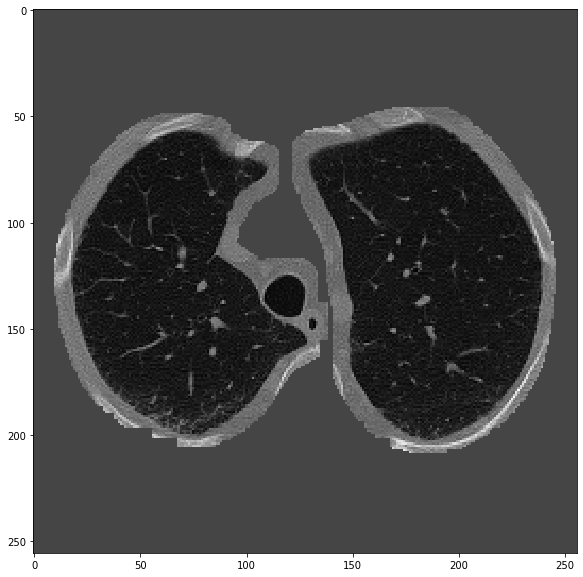

In [12]:
plt.figure(figsize = (10,10))
plt.imshow(X[0,:,:,0], cmap = 'gray')

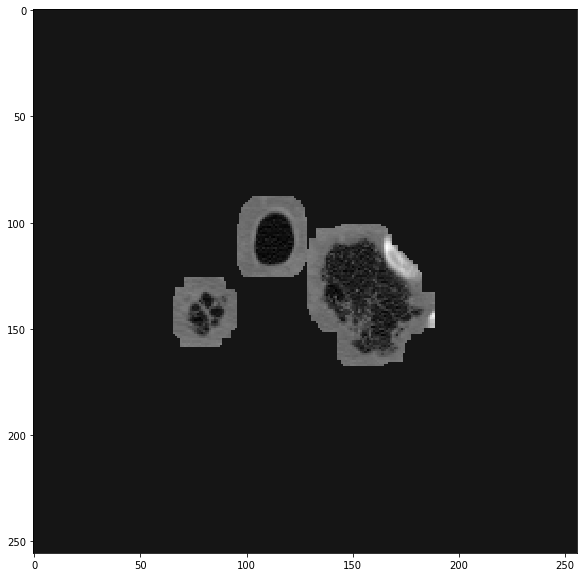

In [13]:
plt.figure(figsize = (10,10))
plt.imshow(X[32,:,:,0], cmap = 'gray')

In [14]:
from tensorflow.keras.layers import Input, Conv2D, Lambda, Conv2DTranspose,  BatchNormalization, Dense, Flatten,MaxPooling2D,Dropout, UpSampling2D,GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD,Adam
import tensorflow as tf
import resnet

## Autoencoder for pixel segmentation

In [15]:
def build_encoder(imsize, latent_dim):
    inputs = Input(shape = (imsize, imsize, 1))
    
    x = Conv2D(64, (5,5), strides = 1, padding = 'same', activation = 'relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (5,5), strides = 2, padding = 'same', activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(latent_dim, (5,5), strides = 2, padding = 'same', activation = 'relu')(x)
    x = BatchNormalization()(x)
    
    enc = Model(inputs, x)
    return enc

def build_decoder(imsize, latent_dim):
    inputs = Input(shape = (int(imsize/4), int(imsize/4), latent_dim))
    
    x = Conv2D(64, (5,5), strides = 1, padding = 'same', activation = 'relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (5,5), strides = 2, padding = 'same', activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (5,5), strides = 2, padding = 'same', activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (5,5), strides = 1, padding = 'same', activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1, (5,5), strides = 1, padding = 'same', activation = 'linear')(x)
    x = BatchNormalization()(x)
    
    dec = Model(inputs, x)
    return dec

In [24]:
imsize = 256
latent_dim = 64
encoder = build_encoder(imsize, latent_dim)
decoder = build_decoder(imsize, latent_dim)

inputs = Input(shape = (imsize, imsize, 1))
encoded = encoder(inputs)
decoded = decoder(encoded)

model = Model(inputs, decoded)

In [25]:
encoder.summary()
decoder.summary()
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 256, 256, 64)      1664      
_________________________________________________________________
batch_normalization_16 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 64)      102464    
_________________________________________________________________
batch_normalization_17 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 64)        102464    
_________________________________________________________________
batch_normalization_18 (Batc (None, 64, 64, 64)        256 

In [26]:
optimizer=SGD(lr=0.1)
loss = 'mse'
metrics = []
model.compile(loss=loss,
              optimizer=optimizer,#keras.optimizers.Adadelta(),
              metrics=metrics)

In [27]:
cnt = 0
batch_size = 32
EPOCHS = 800


stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=6, verbose=1, mode='auto',
    baseline=None, restore_best_weights=True
)
reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, 
                                                     mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.00001)



aug = image_generator2('./filtered_2d', batch_size = batch_size, img_size = imsize)

X_test, y_test = aug.send(None)

model.fit_generator(aug, epochs=EPOCHS, steps_per_epoch=100,validation_data=(X_test, y_test),
             callbacks = [stop, reduce])

  ...
    to  
  ['...']
Train for 100 steps, validate on 32 samples
Epoch 1/800
100/100 [==============================] - 57s 567ms/step - loss: 0.0679 - val_loss: 0.1917
Epoch 2/800
100/100 [==============================] - 51s 506ms/step - loss: 0.0374 - val_loss: 0.1736
Epoch 3/800
100/100 [==============================] - 51s 508ms/step - loss: 0.0322 - val_loss: 0.1304
Epoch 4/800
100/100 [==============================] - 51s 510ms/step - loss: 0.0304 - val_loss: 0.0754
Epoch 5/800
100/100 [==============================] - 51s 511ms/step - loss: 0.0290 - val_loss: 0.0351
Epoch 6/800
100/100 [==============================] - 51s 513ms/step - loss: 0.0270 - val_loss: 0.0243
Epoch 7/800
100/100 [==============================] - 51s 513ms/step - loss: 0.0257 - val_loss: 0.0205
Epoch 8/800
100/100 [==============================] - 54s 542ms/step - loss: 0.0253 - val_loss: 0.0192
Epoch 9/800
100/100 [==============================] - 54s 544ms/step - loss: 0.0240 - val_loss: 0.

In [28]:
model.save_weights('./checkpoints/autoencoder.h5')
encoder.save_weights('./checkpoints/encoder.h5')

In [32]:
pred = model.predict(X_test)
pred = pred.reshape((batch_size, imsize, imsize))
true = X_test.reshape((batch_size, imsize, imsize))

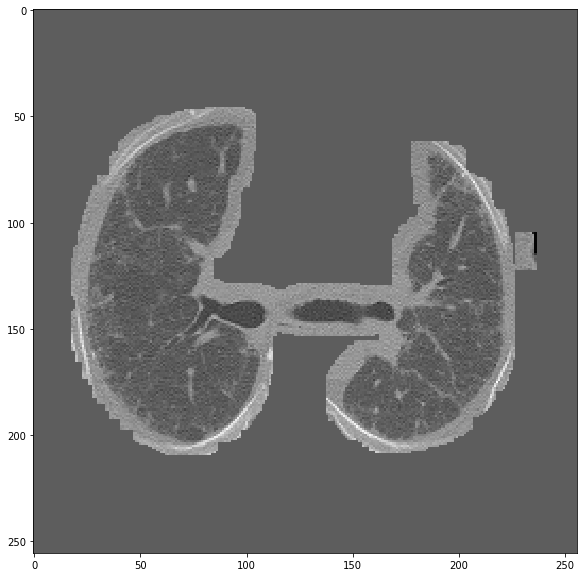

In [43]:
ind = 5

plt.figure(figsize = (10,10))
plt.imshow(true[ind], cmap = 'gray')

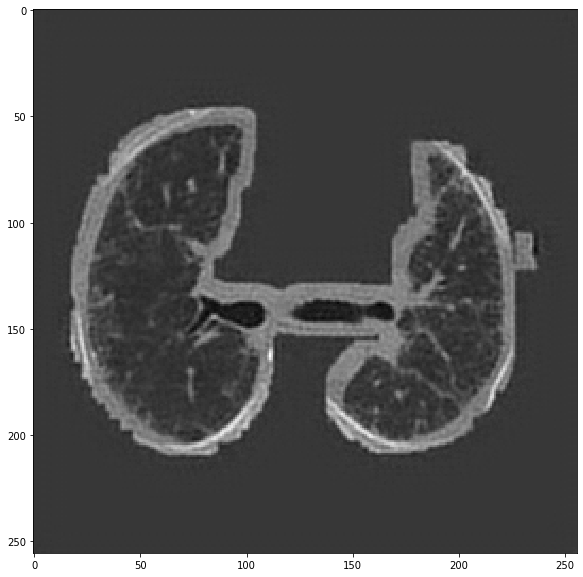

In [44]:
plt.figure(figsize = (10,10))
plt.imshow(pred[ind], cmap = 'gray')

In [45]:
pixpred = encoder.predict(X_test)

In [47]:
pix = []
for elt in pixpred:
    for i in range(64):
        for j in range(64):
            pix.append(elt[i,j,:])
pix = np.array(pix)

In [49]:
import umap

reducer = umap.UMAP(n_neighbors=10, metric='cosine', n_components=10)

# y_test_unsupervised = np.zeros(y_test.shape[0])-1
# y_learn = np.concatenate([y_train, y_test_unsupervised])

embedding = reducer.fit(pix)

Xt = embedding.transform(pix)

C:\Users\gabri\Anaconda3\lib\site-packages\umap\nndescent.py:92: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\Anaconda3\lib\site-packages\umap\utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^


C:\Users\gabri\Anaconda3\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\Anaconda3\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def n

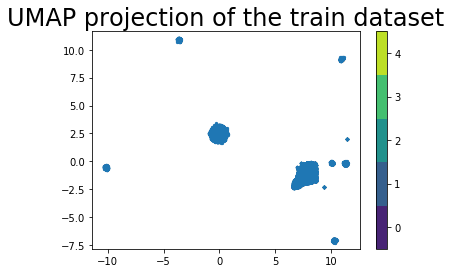

In [50]:
plt.figure(0)
plt.scatter(Xt[:, 0], Xt[:, 1], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the train dataset', fontsize=24);

In [154]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(pix)

y_cluster = kmeans.labels_

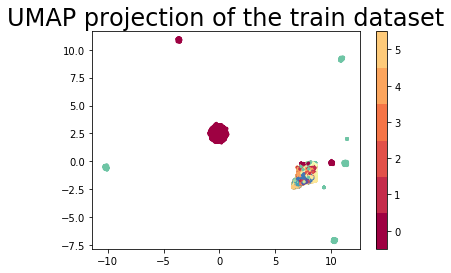

In [155]:
plt.figure(0)
plt.scatter(Xt[:, 0], Xt[:, 1],c = y_cluster, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(7)-0.5).set_ticks(np.arange(6))
plt.title('UMAP projection of the train dataset', fontsize=24);

In [156]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

def show_clusters(img, pix, clf, reducer):
    
    
    pix = pix.reshape((64*64,64))
#     pix = reducer.transform(pix)
    
    label = clf.predict(pix)
    
    mask = label.reshape(64,64)
    
    mask1 = mask.reshape((1,64,64,1))
    mask2 = UpSampling2D(4)(mask1)[0,:,:,0]
    
    plt.figure(figsize = (14,14))
    plt.imshow(img, cmap = 'gray')
    plt.title('original picture')
    
    for elt in np.unique(kmeans.labels_):
        plt.figure(elt, figsize = (14,14))
        fig, ax = image_show(true[ind])
        ax.imshow(mask2 == elt, alpha=0.3);
        plt.title('cluster '+ str(elt))
    
    
    
    

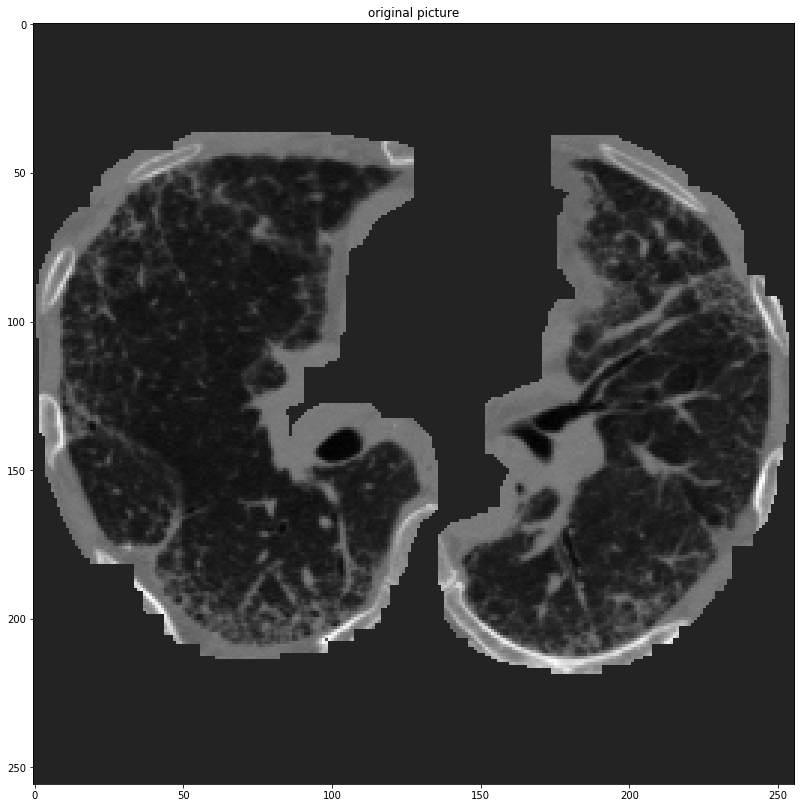

<Figure size 1008x1008 with 0 Axes>

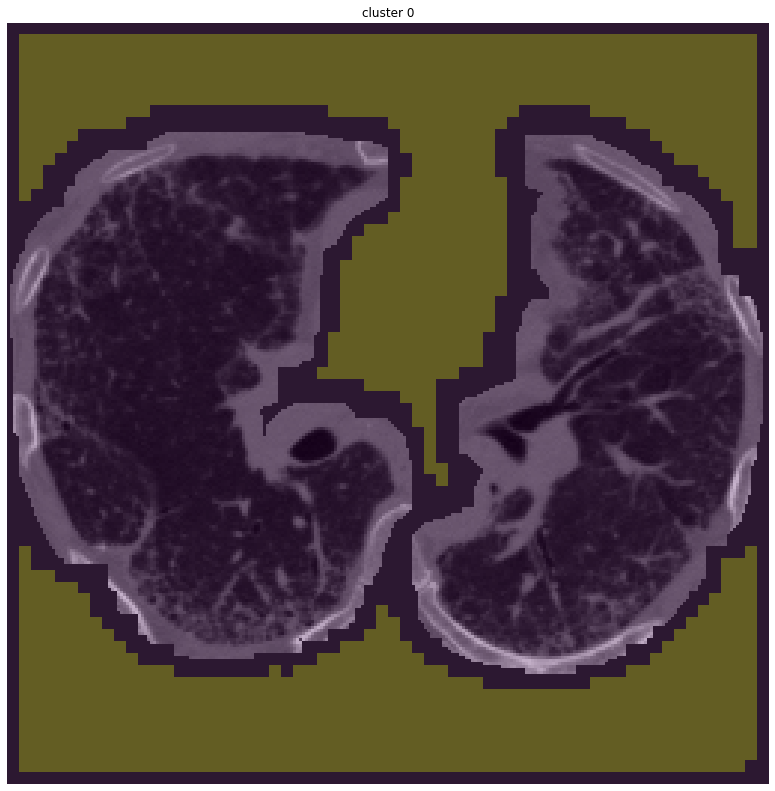

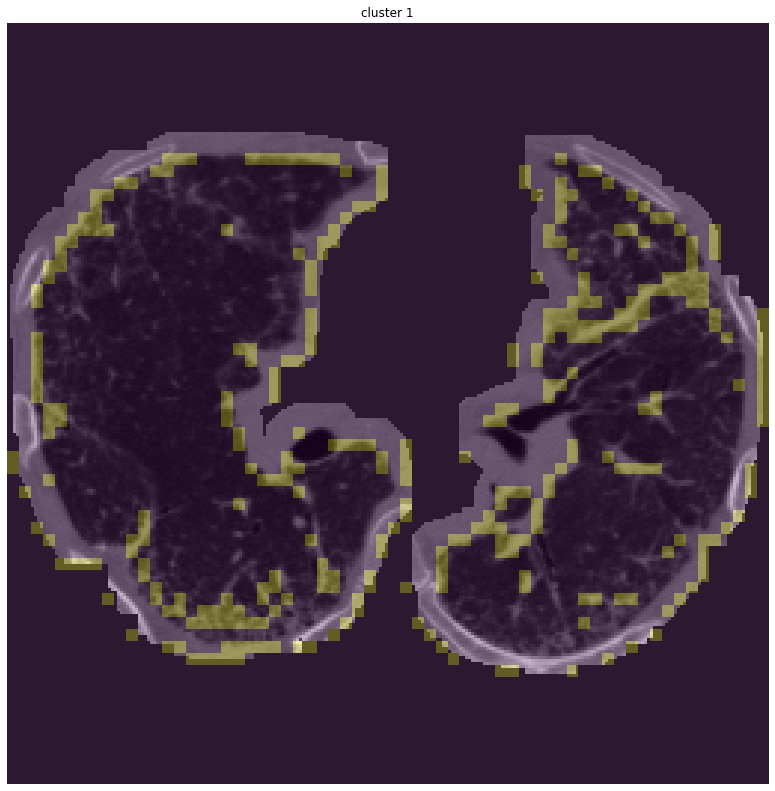

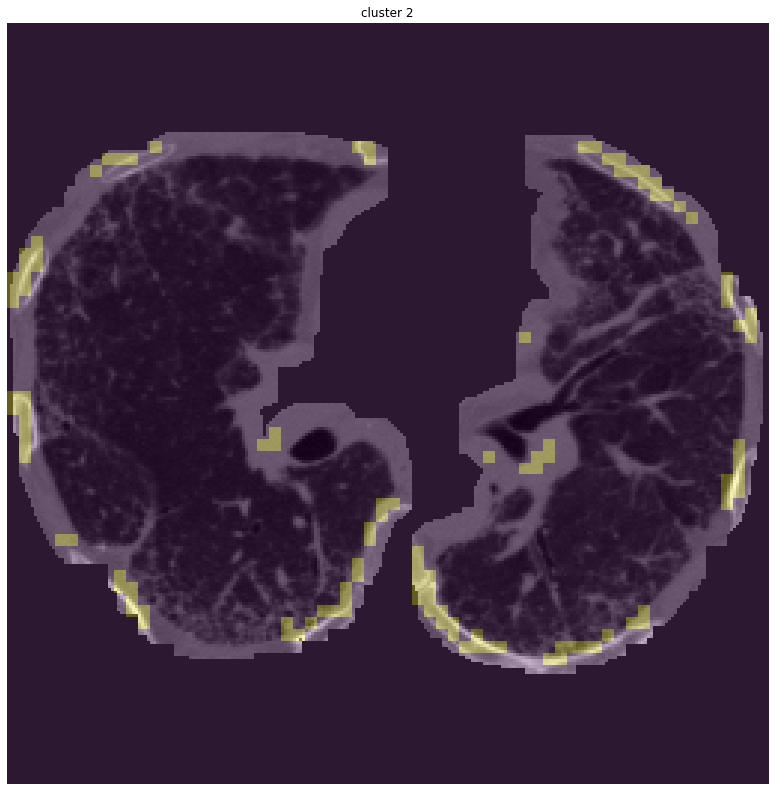

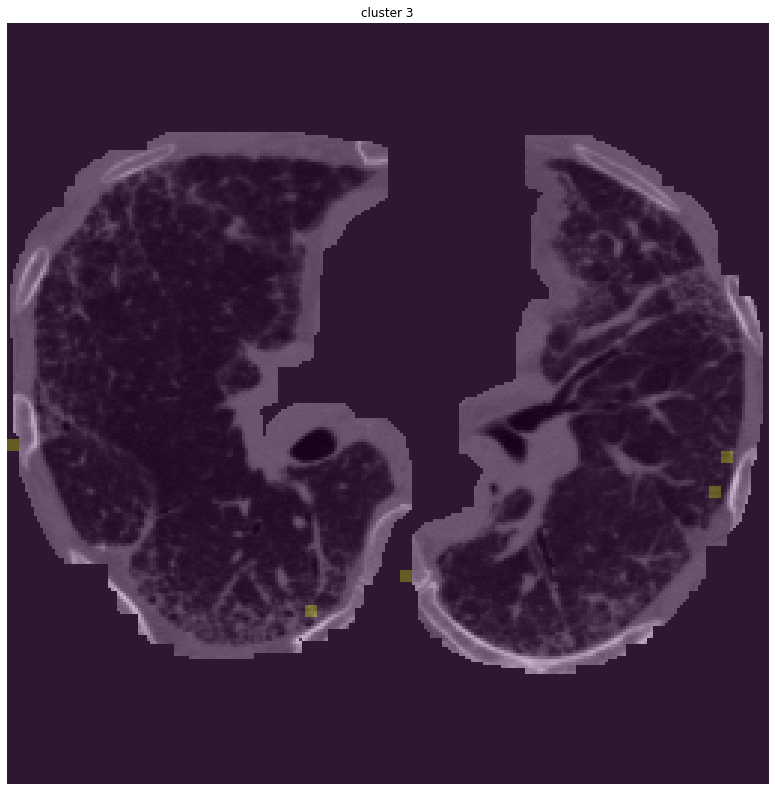

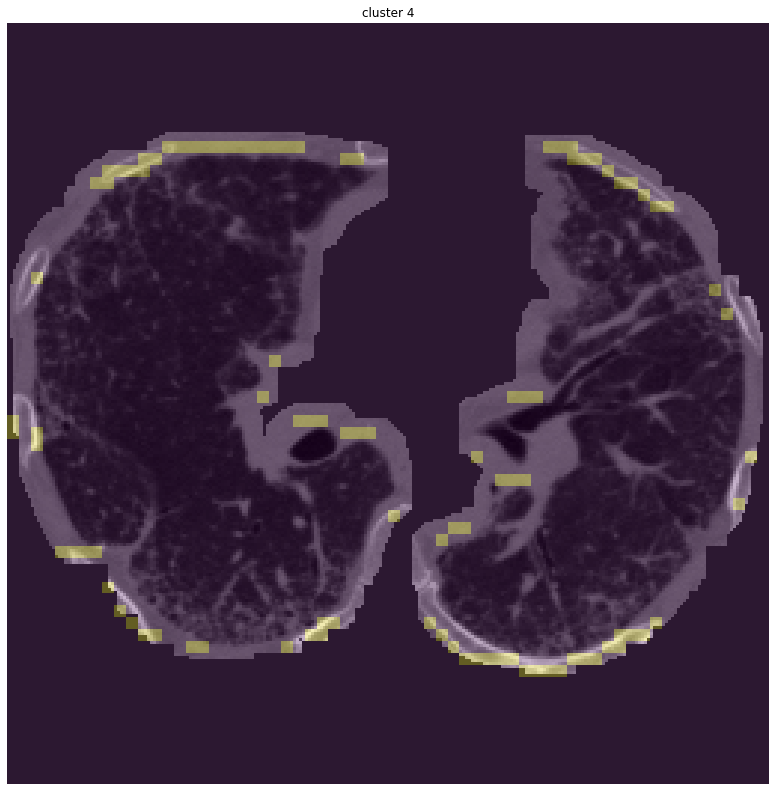

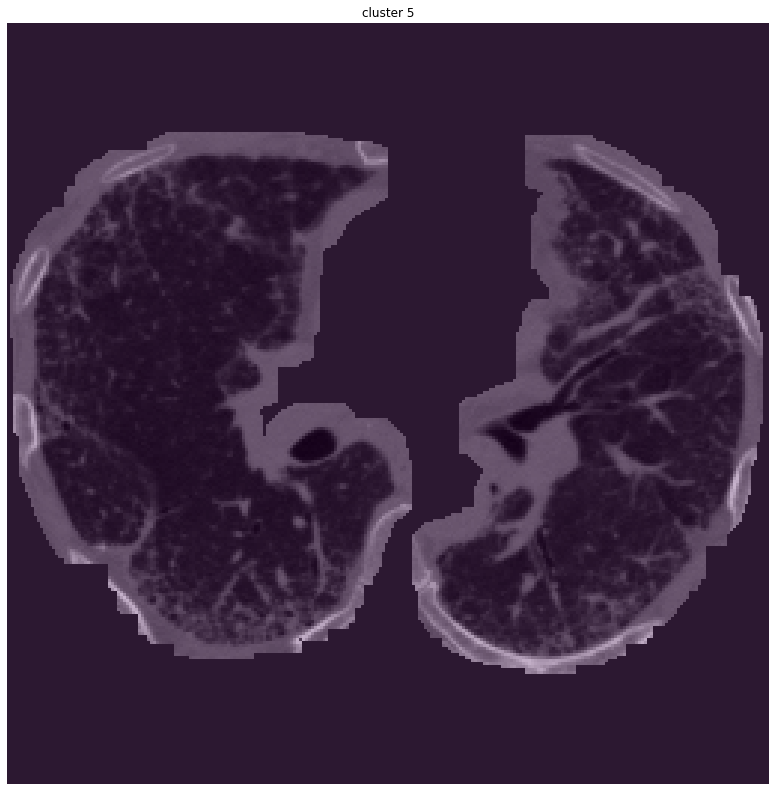

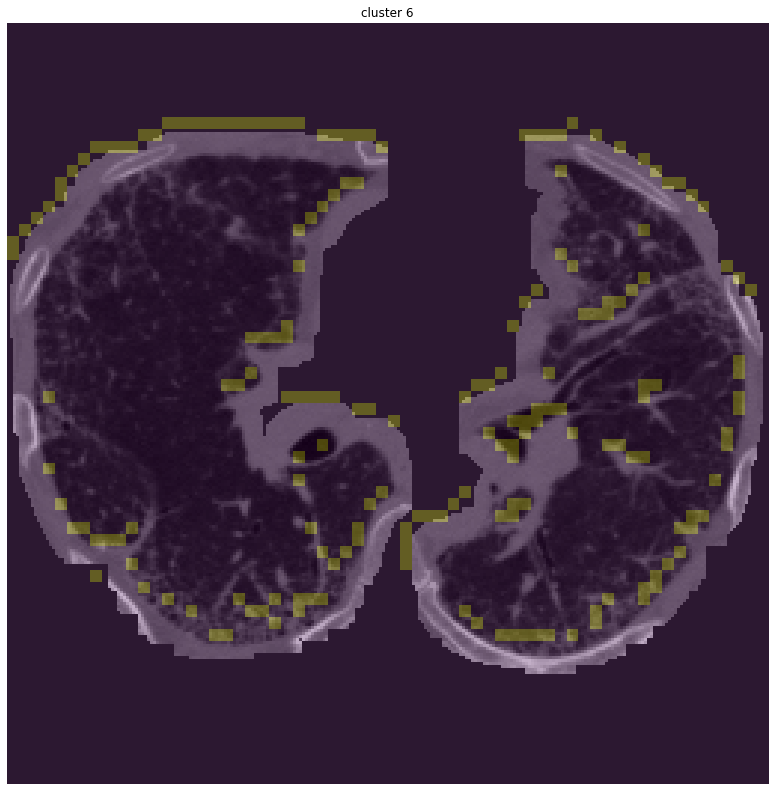

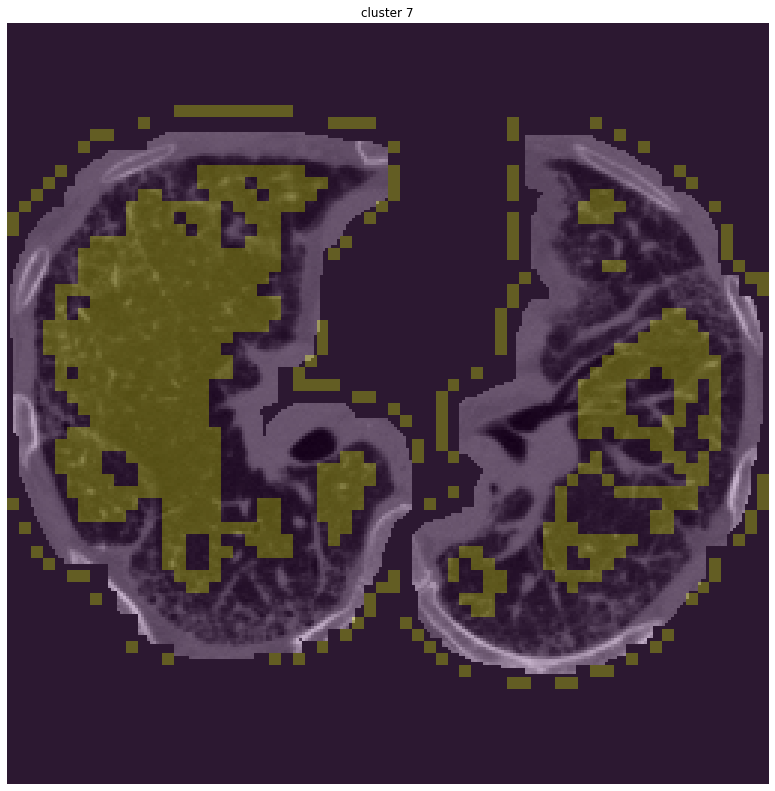

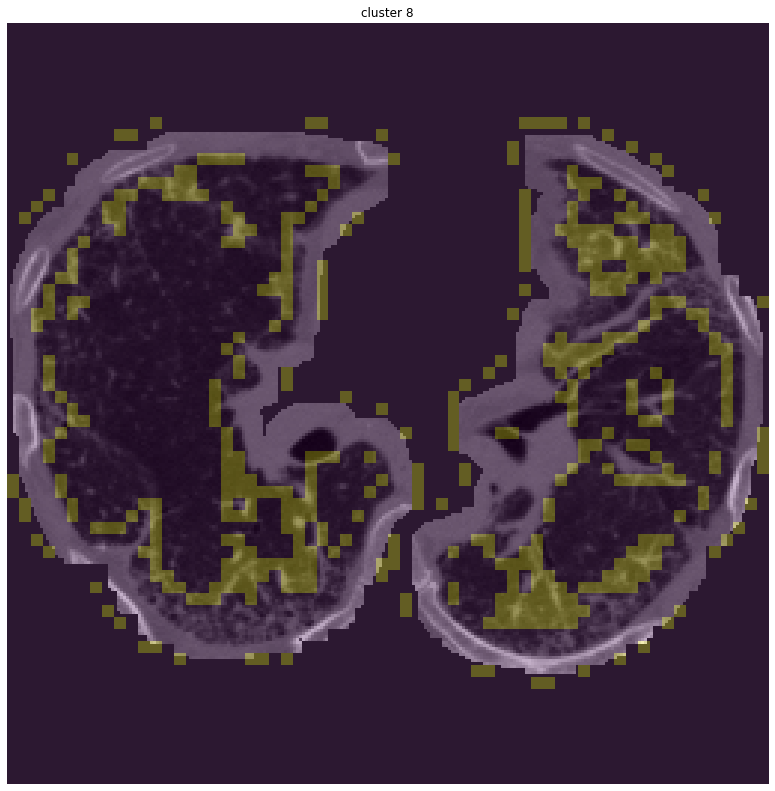

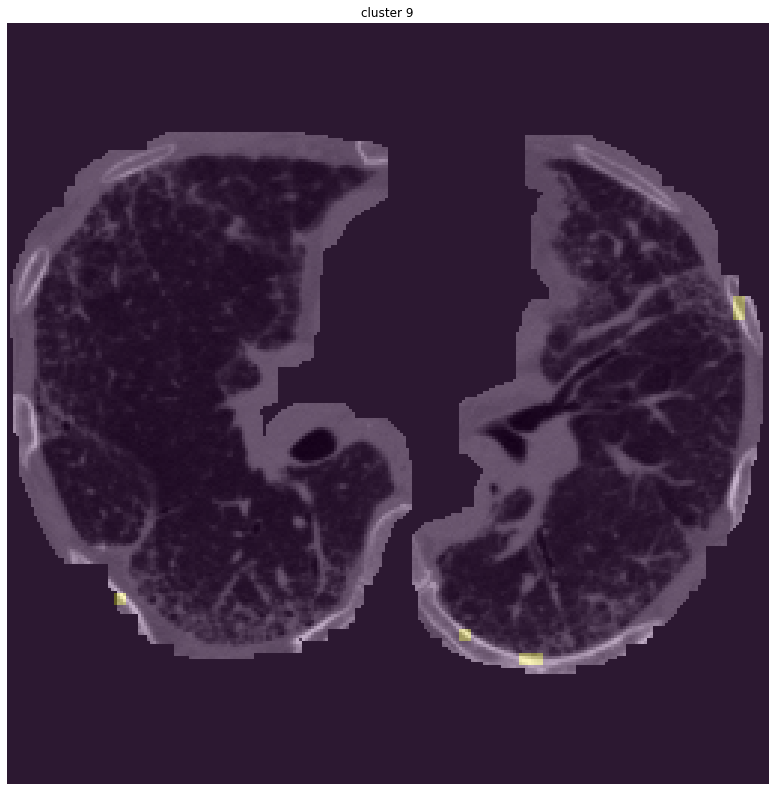

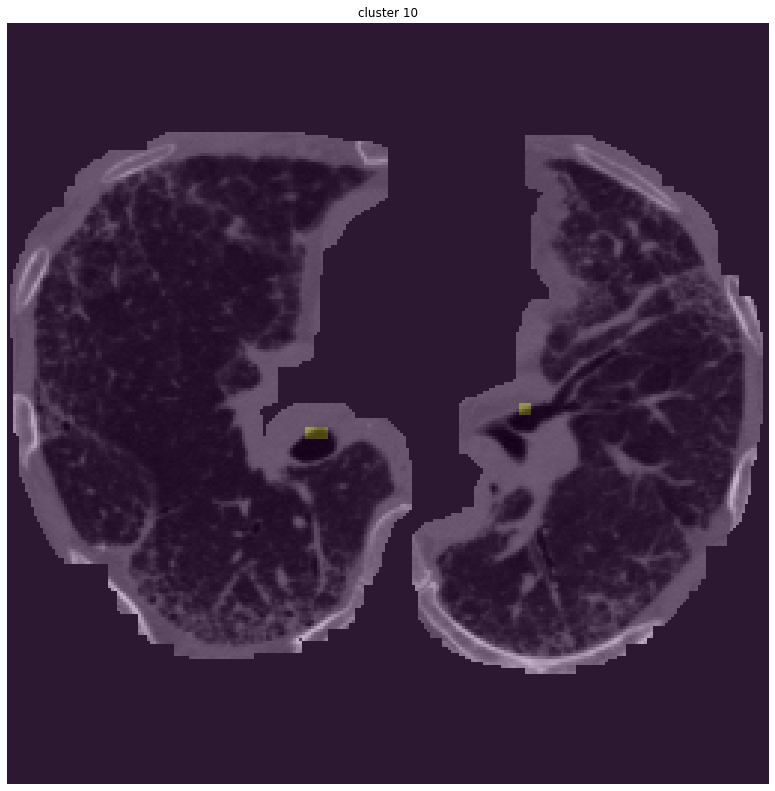

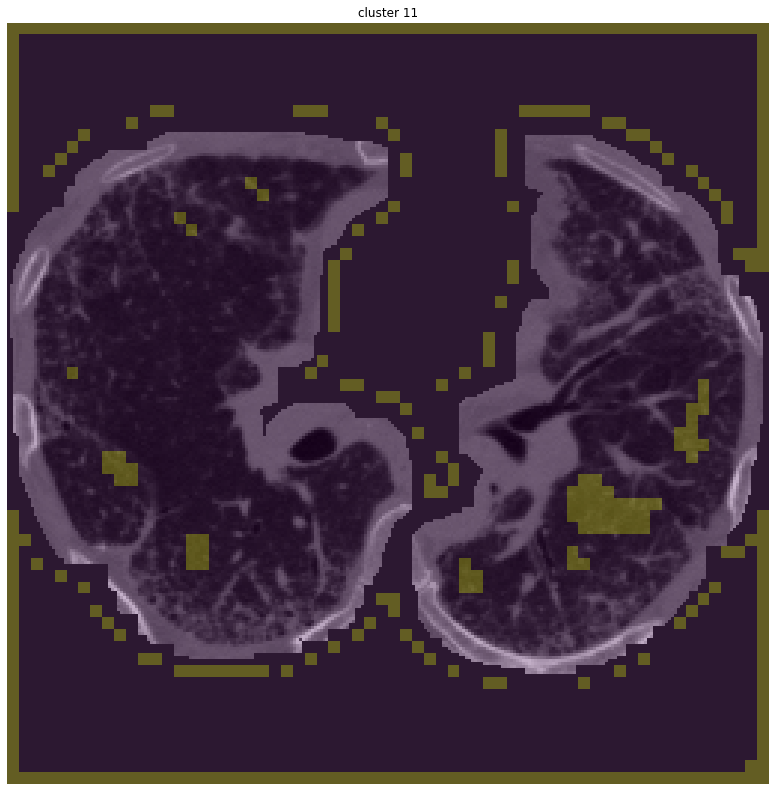

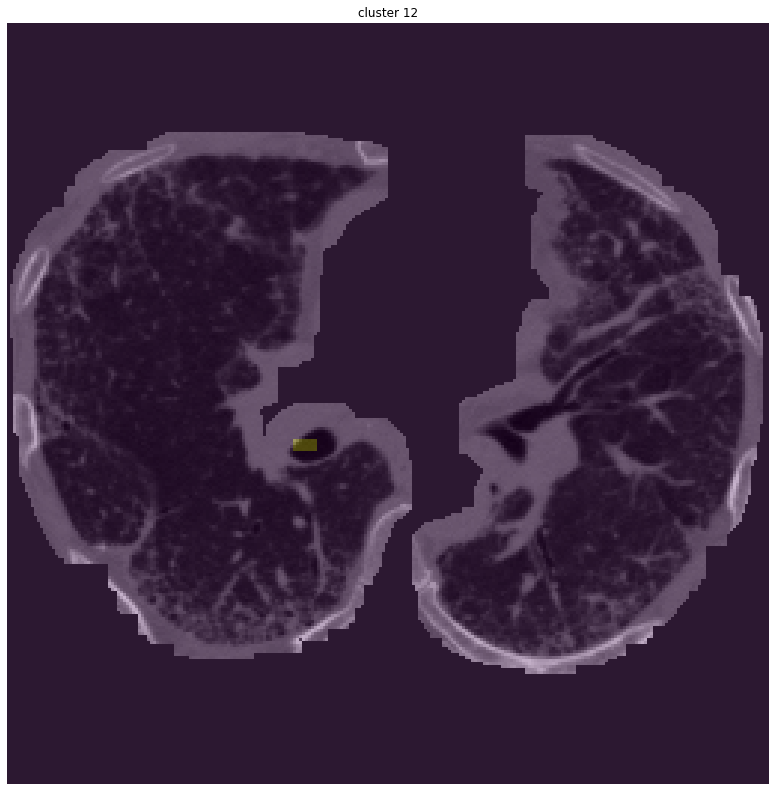

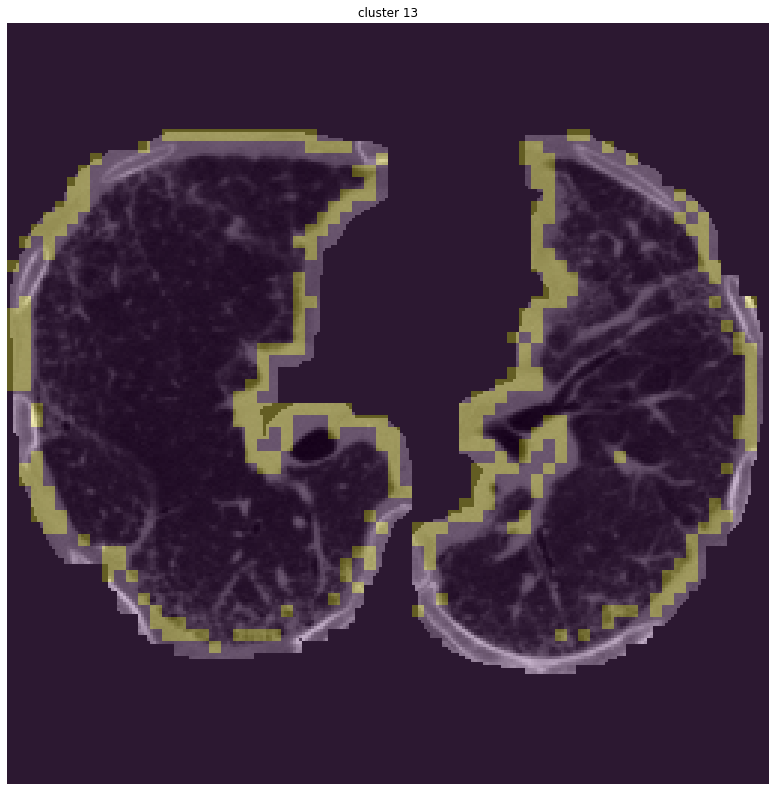

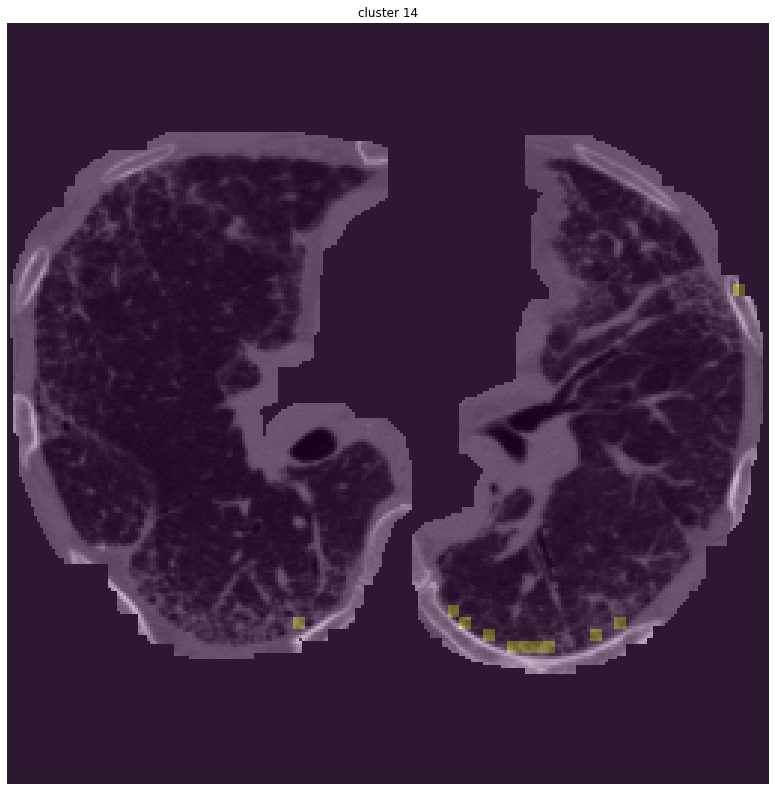

In [157]:
ind = 2
show_clusters(true[ind], pixpred[ind], kmeans, reducer)


## Contrastive loss approach

In [ ]:
def build_sub_img(img, size):
    
    n = int(size/2)
    
    img1 = img[~np.all(img == 0, axis=1)]
    img1 = img1[:,~np.all(img1 == 0, axis=0)]
    
#     print(img1.shape)
    try:
        x = random.choice(range(0, img1.shape[0]-size))
        y = random.choice(range(0, img1.shape[1]-size))

        img2 = img1[x:x+size, y:y+size]
    except:
        img2 = img1
    x1 = random.choice(range(0, img2.shape[0]-n))
    y1 = random.choice(range(0, img2.shape[1]-n))
    x2 = random.choice(range(0, img2.shape[0]-n))
    y2 = random.choice(range(0, img2.shape[1]-n))
    
    img3 = img2[x1:x1+n, y1:y1+n]
    img4 = img2[x2:x2+n, y2:y2+n]
    
    k1 = random.choice(range(4))
    k2 = random.choice(range(4))
    
    img3 = np.rot90(img3, k=k1, axes=(0, 1))
    img4 = np.rot90(img4, k=k2, axes=(0, 1))
    
    return img3, img4

In [ ]:

build = resnet.ResnetBuilder()
res = build.build_resnet_18((64,64,1),64)

inputs = Input(shape = (64,64,1))
latent = res(inputs)
proj = Dense(512, activation = 'relu')(latent)
proj = Dense(512, activation = 'relu')(proj)
proj = Dense(512, activation = 'relu')(proj)
proj = Dense(512, activation = 'linear')(proj)

model = Model(inputs, proj)


In [ ]:
def contrastive_loss(true, hidden,
                         hidden_norm=True,
                         temperature=1.0,
                         tpu_context=None,
                         weights=1.0):
    """Compute loss for model.
      Args:
        hidden: hidden vector (`Tensor`) of shape (bsz, dim).
        hidden_norm: whether or not to use normalization on the hidden vector.
        temperature: a `floating` number for temperature scaling.
        tpu_context: context information for tpu.
        weights: a weighting number or vector.
      Returns:
        A loss scalar.
        The logits for contrastive prediction task.
        The labels for contrastive prediction task.
      """
  # Get (normalized) hidden1 and hidden2.

    LARGE_NUM = 1e9

    if hidden_norm:
        hidden = tf.math.l2_normalize(hidden, -1)
    hidden1, hidden2 = tf.split(hidden, 2, 0)
    batch_size = tf.shape(hidden1)[0]

  # Gather hidden1/hidden2 across replicas and create local labels.

    
    hidden1_large = hidden1
    hidden2_large = hidden2
    labels = tf.one_hot(tf.range(batch_size), batch_size * 2)
    masks = tf.one_hot(tf.range(batch_size), batch_size)

    logits_aa = tf.matmul(hidden1, hidden1_large, transpose_b=True) / temperature
    logits_aa = logits_aa - masks * LARGE_NUM
    logits_bb = tf.matmul(hidden2, hidden2_large, transpose_b=True) / temperature
    logits_bb = logits_bb - masks * LARGE_NUM
    logits_ab = tf.matmul(hidden1, hidden2_large, transpose_b=True) / temperature
    logits_ba = tf.matmul(hidden2, hidden1_large, transpose_b=True) / temperature

    loss_a = tf.nn.softmax_cross_entropy_with_logits(
      labels, tf.concat([logits_ab, logits_aa], 1))
    loss_b = tf.nn.softmax_cross_entropy_with_logits(
      labels, tf.concat([logits_ba, logits_bb], 1))
    loss = loss_a + loss_b

    return loss

In [ ]:
optimizer=SGD(lr=0.1)
loss = contrastive_loss
metrics = []
model.compile(loss=loss,
              optimizer=optimizer,#keras.optimizers.Adadelta(),
              metrics=metrics)

In [ ]:
cnt = 0
batch_size = 64
EPOCHS = 800


stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=20, verbose=1, mode='auto',
    baseline=None, restore_best_weights=True
)
reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, 
                                                     mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.00001)



aug = image_generator('./filtered_2d', batch_size = 64, img_size = 128)

X_test, y_test = aug.send(None)

model.fit_generator(aug, epochs=EPOCHS, steps_per_epoch=500,validation_data=(X_test, y_test),
             verbose=1, callbacks = [stop, reduce])

In [ ]:
model.save_weights('./checkpoints/contrastive.h5')

In [ ]:
res.save_weights('./checkpoints/resnet_contrastive.h5')

In [ ]:
aug = image_generator('./filtered_2d', batch_size = 1024, img_size = 128)

X, Y = aug.send(None)

In [ ]:
pred = model.predict(X)

In [ ]:
import umap

reducer = umap.UMAP(n_neighbors=10, metric='cosine', n_components=10)

# y_test_unsupervised = np.zeros(y_test.shape[0])-1
# y_learn = np.concatenate([y_train, y_test_unsupervised])

embedding = reducer.fit(pred)

Xt = embedding.transform(pred)

In [ ]:

plt.figure(0)
plt.scatter(Xt[:, 0], Xt[:, 1], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the train dataset', fontsize=24);

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=0).fit(pred)

y_cluster = kmeans.labels_

In [ ]:
plt.figure(0)
plt.scatter(Xt[:, 0], Xt[:, 1],c = y_cluster, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(7)-0.5).set_ticks(np.arange(6))
plt.title('UMAP projection of the train dataset', fontsize=24);

In [ ]:
np.unique(y_cluster)

In [ ]:
X1 = X.reshape((X.shape[0], 64,64))

In [ ]:
vert = 4
hor = 3

cl = 0

fig, ax = plt.subplots(vert, hor, figsize=[12, 12])
for i in range(vert):
    for j in range(hor):
        ax[i,j].imshow(X1[y_cluster == cl][i*hor + j], cmap = 'gray')

# ax[0, 0].set_title("Original")
# ax[0, 0].imshow(img, cmap='gray')
    

In [ ]:
plt.imshow(X1[y_cluster == 3][20], cmap = 'gray')